In [55]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import du df

In [56]:
data = pd.read_csv('./merge_v3_0.csv', sep=';')
df = data
df

,faits,tauxpourmille,Code département,Tableau1AutresdpensesdaidesocialeTotalnetpardpartement31_2021,Tableau1Dpensesnettestotalesdaideauxpersonnesgespardpartement3_2021,Tableau1Dpensesnettestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux18_2021,Tableau1Dpensestotalesnettesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement1_2021,Tableau2AutresdpensesdaidesocialeTotalbrutpardpartement32_2021,Tableau2Dpensesbrutestotalesdaideauxpersonnesgespardpartement4_2021,Tableau2Dpensesbrutestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux19_2021,...,[5;10[,[60;65[,[65;70[,[70;75[,[75;80[,[80;85[,[85;90[,[90;95[,[95;99+],Nombre de créations d'entreprises
0,24042,40.0,1,28330.402,57871.872,58489.972,271646.079,29370.243,58953.440,61402.876,...,45890,39970,35690,32640,22900,15440,11100,5930,2350,8417
1,22815,46.4,2,20410.185,79422.249,69917.258,378500.838,22234.394,80497.863,74140.992,...,32450,35000,33460,31240,19340,13610,10650,5330,1630,4422
2,12755,39.5,3,19504.452,62041.207,45931.680,241149.189,21141.589,62464.142,47682.243,...,16370,24080,24080,24520,17370,12830,10010,5390,1890,3355
3,7983,48.9,4,-363.542,21691.652,21916.247,90585.188,1770.574,21837.525,22340.995,...,8640,12230,12150,11670,8430,6140,4370,2210,870,2629
4,6136,43.6,5,11209.211,18581.219,11538.917,83203.517,13788.194,19099.139,12081.292,...,7350,10730,10350,9670,6820,4700,3650,1940,660,2484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,67826,55.6,91,41227.902,161867.162,343800.984,1356769.043,44195.407,191048.341,375709.749,...,92160,69800,56800,52300,37100,27250,20400,9930,3410,23093
89,95239,61.5,92,124030.658,126776.542,92724.684,855031.794,125753.524,132466.699,137897.228,...,107350,82630,67350,63950,45290,32970,24960,13900,5940,36273
90,132018,84.4,93,68718.570,81546.883,149803.225,670707.035,72036.717,88439.622,155827.168,...,123560,81500,66240,55740,35650,24680,17560,8220,2840,38726
91,86522,65.7,94,185727.703,80791.628,65466.919,475640.315,188315.073,81005.829,65467.169,...,90800,75660,61790,55820,38410,27780,21500,11580,4540,28800


## Nous nettoyons les données en enlevant les candidats et laissant juste le gagnant, et puis nous enlevons d'autres colonnes inutiles

In [57]:

# Prendre les colonnes intéressantes
colonnes_a_garder = ['code_departement','tauxpourmille','gagnant']


df_winner = df
df_winner.drop(columns=['DLF', 'EELV', 'LFI', 'LR', 'LO', 'LREM', 'NPA', 'PCF', 'PS', 'RN', 'Reconuête', 'Résistons', 'abstentions', 'blancs', 'nuls', 'faits', 'code_departement_1', 'Département', 'Code département'], inplace=True)
df_winner.columns = df_winner.columns.str.strip('[]')

# df_winner = df[colonnes_a_garder]
df_winner

,tauxpourmille,Tableau1AutresdpensesdaidesocialeTotalnetpardpartement31_2021,Tableau1Dpensesnettestotalesdaideauxpersonnesgespardpartement3_2021,Tableau1Dpensesnettestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux18_2021,Tableau1Dpensestotalesnettesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement1_2021,Tableau2AutresdpensesdaidesocialeTotalbrutpardpartement32_2021,Tableau2Dpensesbrutestotalesdaideauxpersonnesgespardpartement4_2021,Tableau2Dpensesbrutestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux19_2021,Tableau2Dpensestotalesbrutesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement2_2021,Tableau3Dpensesbrutesdaidedomicilepardpartement13_2021,...,5;10,60;65,65;70,70;75,75;80,80;85,85;90,90;95,95;99+,Nombre de créations d'entreprises
0,40.0,28330.402,57871.872,58489.972,271646.079,29370.243,58953.440,61402.876,282716.891,21092.960,...,45890,39970,35690,32640,22900,15440,11100,5930,2350,8417
1,46.4,20410.185,79422.249,69917.258,378500.838,22234.394,80497.863,74140.992,386638.100,18560.380,...,32450,35000,33460,31240,19340,13610,10650,5330,1630,4422
2,39.5,19504.452,62041.207,45931.680,241149.189,21141.589,62464.142,47682.243,250660.371,16876.566,...,16370,24080,24080,24520,17370,12830,10010,5390,1890,3355
3,48.9,-363.542,21691.652,21916.247,90585.188,1770.574,21837.525,22340.995,93450.437,4678.180,...,8640,12230,12150,11670,8430,6140,4370,2210,870,2629
4,43.6,11209.211,18581.219,11538.917,83203.517,13788.194,19099.139,12081.292,88577.502,6361.786,...,7350,10730,10350,9670,6820,4700,3650,1940,660,2484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,55.6,41227.902,161867.162,343800.984,1356769.043,44195.407,191048.341,375709.749,1443808.961,85068.051,...,92160,69800,56800,52300,37100,27250,20400,9930,3410,23093
89,61.5,124030.658,126776.542,92724.684,855031.794,125753.524,132466.699,137897.228,916457.165,42049.724,...,107350,82630,67350,63950,45290,32970,24960,13900,5940,36273
90,84.4,68718.570,81546.883,149803.225,670707.035,72036.717,88439.622,155827.168,698348.139,36439.128,...,123560,81500,66240,55740,35650,24680,17560,8220,2840,38726
91,65.7,185727.703,80791.628,65466.919,475640.315,188315.073,81005.829,65467.169,479161.214,23769.227,...,90800,75660,61790,55820,38410,27780,21500,11580,4540,28800


## Premier calcul de l'accuracy avec des paramètres par défaut du modèle: nous obtenons 0.71

In [58]:
# Diviser les données en features (X) et la cible (y)
X = df_winner.drop(columns=['gagnant'])
y = df_winner['gagnant']

# Convertir les colonnes catégoriques en type 'category'
# cat_cols = X.select_dtypes(include=['object']).columns
# X[cat_cols] = X[cat_cols].astype('category')

# Encoder les catégories en valeurs numériques
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Créer un objet DMatrix pour XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Spécifier les paramètres du modèle XGBoost
params = {
    'objective': 'multi:softmax',  # Pour une classification multi-classes
    'num_class': len(np.unique(y)),  # Nombre de classes dans la cible
    'eval_metric': 'merror'         # Métrique d'évaluation
}


num_rounds = 1000  # Nombre d'itérations d'entraînement
cv_results = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=5, metrics='merror', early_stopping_rounds=1000, seed=42)


print(cv_results)
print("Précision moyenne :", 1 - cv_results['test-merror-mean'].iloc[-1])

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0             0.045802          0.020360          0.355556         0.088797
1             0.024252          0.015809          0.312281         0.025784
2             0.021550          0.010865          0.312281         0.025784
3             0.013477          0.008547          0.301754         0.032158
4             0.008108          0.006620          0.280117         0.042989
..                 ...               ...               ...              ...
995           0.000000          0.000000          0.281871         0.099889
996           0.000000          0.000000          0.281871         0.099889
997           0.000000          0.000000          0.281871         0.099889
998           0.000000          0.000000          0.281871         0.099889
999           0.000000          0.000000          0.281871         0.099889

[1000 rows x 4 columns]
Précision moyenne : 0.7181286549707603


## Nous testons différents paramètres grâce a GridSearchCV qui nous permet de séléctionner le meilleiur paramètre parmis une liste

In [74]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Définir les hyperparamètres que vous souhaitez rechercher dans une grille
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y)), eval_metric='merror')

# Définir la stratégie de validation croisée (K-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Utiliser GridSearchCV pour rechercher les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_search.fit(X, y)

# Afficher les meilleurs hyperparamètres trouvés et le meilleur score
print("Meilleurs hyperparamètres trouvés :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

Meilleurs hyperparamètres trouvés : {'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9}
Meilleur score : 0.8385964912280702


## Nous calculons à nouveau l'accuracy avec les nouveaux paramètres nous obtenons 0.74

In [60]:
from sklearn.model_selection import StratifiedKFold

# Test d'optimisation du model avec les paramètres
params_opti = {
    'objective': 'multi:softmax',  # Objectif de la fonction de perte pour une classification multi-classes
    'num_class': len(np.unique(y)),  # Nombre de classes dans la cible
    'eval_metric': 'merror',         # Métrique d'évaluation (taux d'erreur de classification)
    'learning_rate': 0.2,            # Taux d'apprentissage (vitesse à laquelle le modèle apprend)
    'max_depth': 5,                  # Profondeur maximale de chaque arbre
    'min_child_weight': 3,           # Poids minimum d'un nœud enfant (contrôle de l'overfitting)
    'gamma': 0.2,                    # Réduction minimale de la perte requise pour diviser un nœud
    'subsample': 0.8,                # Fraction des échantillons à utiliser lors de la construction de chaque arbre
    'colsample_bytree': 1.0          # Fraction des caractéristiques à utiliser lors de la construction de chaque arbre
}

num_rounds = 700  # Nombre d'itérations d'entraînement
# Définir la stratégie de validation croisée (K-fold)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Utiliser xgb.cv avec les paramètres et la validation croisée définis
cv_results_test = xgb.cv(params=params_opti, dtrain=dtrain, num_boost_round=num_rounds, folds=kfold, metrics='merror', early_stopping_rounds=1000, seed=42)

print(cv_results_test)
print("Précision moyenne :", 1 - cv_results_test['test-merror-mean'].iloc[-1])


The least populated class in y has only 6 members, which is less than n_splits=10.


     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0             0.158936          0.024662          0.268889         0.123008
1             0.142126          0.027147          0.278889         0.115090
2             0.132587          0.023336          0.267778         0.081718
3             0.127783          0.026943          0.267778         0.107778
4             0.115863          0.022499          0.290000         0.107548
..                 ...               ...               ...              ...
695           0.022676          0.006369          0.267778         0.081718
696           0.022676          0.006369          0.267778         0.081718
697           0.022676          0.006369          0.267778         0.081718
698           0.022676          0.006369          0.267778         0.081718
699           0.021486          0.004720          0.256667         0.079574

[700 rows x 4 columns]
Précision moyenne : 0.7433333333333333


## Nous allons maintenant analyser les résulats et voir comment le modèle fonctionne, ici nous calculons l'importance de chaque données dans le modèle

In [61]:
# Entraîner un modèle XGBoost sur l'ensemble des données
model = xgb.train(params_opti, dtrain, num_boost_round=num_rounds)

# Obtenir l'importance des caractéristiques
importance = model.get_score(importance_type='weight')

# Afficher l'importance des caractéristiques
print(importance)

{'tauxpourmille': 37.0, 'Tableau1AutresdpensesdaidesocialeTotalnetpardpartement31_2021': 6.0, 'Tableau1Dpensesnettestotalesdaideauxpersonnesgespardpartement3_2021': 3.0, 'Tableau1Dpensesnettestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux18_2021': 5.0, 'Tableau1Dpensestotalesnettesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement1_2021': 9.0, 'Tableau2AutresdpensesdaidesocialeTotalbrutpardpartement32_2021': 10.0, 'Tableau2Dpensesbrutestotalesdaideauxpersonnesgespardpartement4_2021': 12.0, 'Tableau2Dpensesbrutestotalesdaidesocialelenfancepardpartementhorsdpensesdepersonnellexceptiondecellesliesauxassistantsfamiliaux19_2021': 1.0, 'Tableau2Dpensestotalesbrutesdaidesocialeycomprislaidemdicalegnralelesfraiscommunsetlesdpensesdepersonnelpardpartement2_2021': 1.0, 'Tableau3Dpensesbrutestotalesdallocationspardpartement20_2021': 16.0, 'Tableau4DpensesbrutesdactionsducativesAEDetAEMOhorsdpensesde

## La même chose mais sous forme graphique


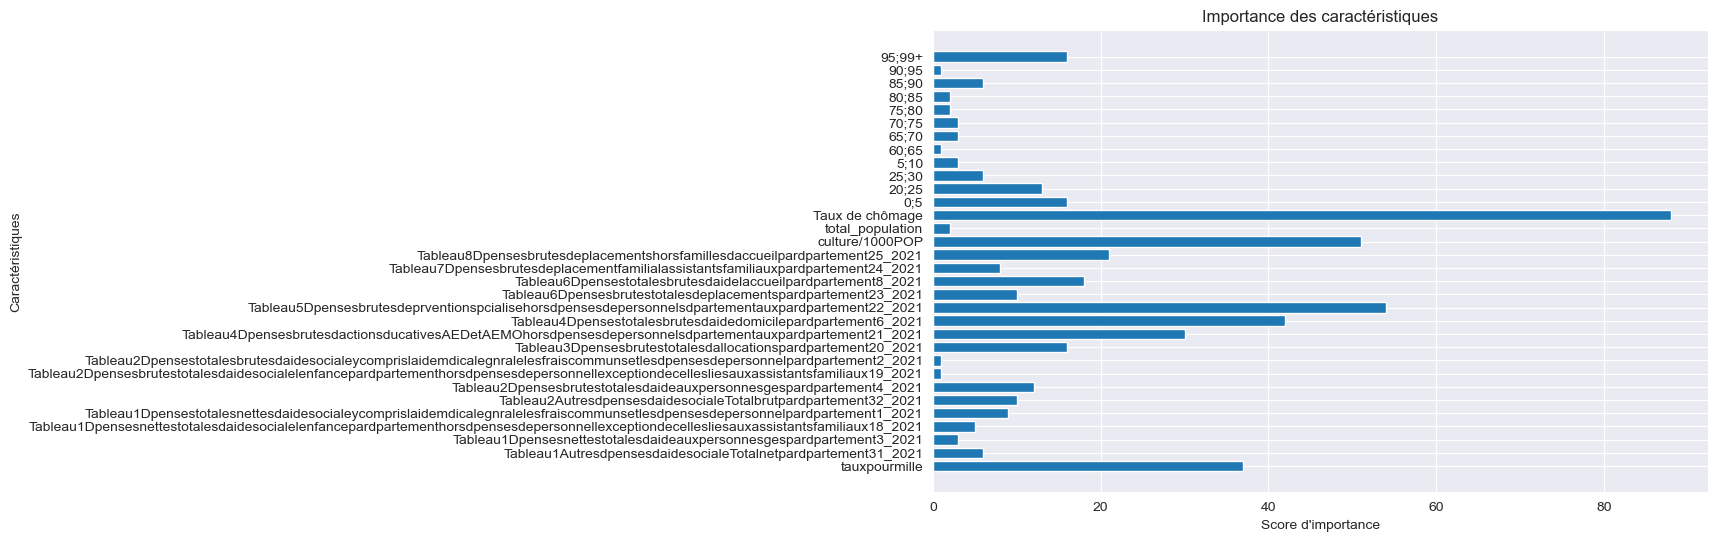

In [62]:

# Créer une liste de noms de caractéristiques et une liste de scores d'importance
feature_names = list(importance.keys())
scores = list(importance.values())

# Créer un graphique à barres pour afficher l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_names, scores)
plt.xlabel('Score d\'importance')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques')
plt.show()

## Avec shap nous mesurons l'impact de chaque donnée

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


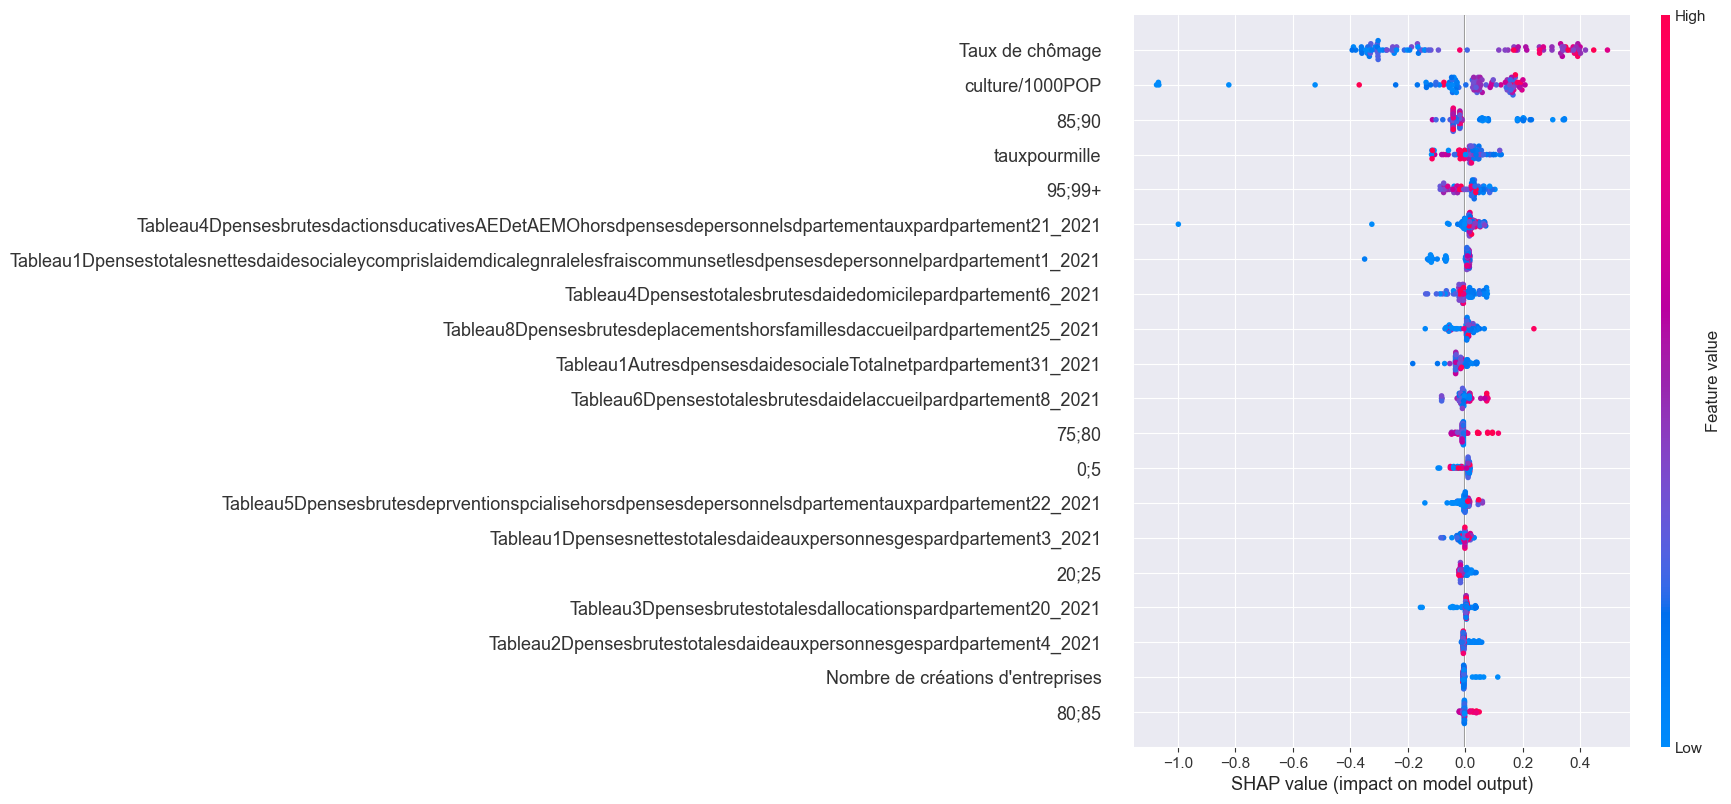

In [63]:
import shap

X2 = X

dtrain2 = xgb.DMatrix(X2, label=y)

params2 = {
    'eval_metric': 'merror'         # Métrique d'évaluation
}

model2 = xgb.train(params2, dtrain2, num_boost_round=num_rounds)

explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X2)

# Afficher le résumé des valeurs SHAP
shap.summary_plot(shap_values, X2)

## Nous pouvons établir maintenant l'importance de chaque donnée par rapport à chaque candidat qui a gagné 

In [64]:
# Analyse des différents impact par parties

# Créer un ensemble de données pour LREM
data_LREM = df_winner[df_winner['gagnant'] == 'LREM']

# Initialiser l'explorateur SHAP avec votre modèle XGBoost
explainer = shap.TreeExplainer(model2)

# Calculer les valeurs SHAP pour chaque ensemble de données

# Pour LREM
shap_values_LREM = explainer.shap_values(data_LREM.drop(columns=['gagnant']))

In [65]:
# Créer un ensemble de données pour RN
data_RN = df_winner[df_winner['gagnant'] == 'RN  ']
# Calculer les valeurs SHAP pour chaque ensemble de données
shap_values_RN = explainer.shap_values(data_RN.drop(columns=['gagnant']))

In [66]:
# Créer un ensemble de données pour LFI
data_LFI = df_winner[df_winner['gagnant'] == 'LFI ']
# Calculer les valeurs SHAP pour chaque ensemble de données
shap_values_LFI = explainer.shap_values(data_LFI.drop(columns=['gagnant']))

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


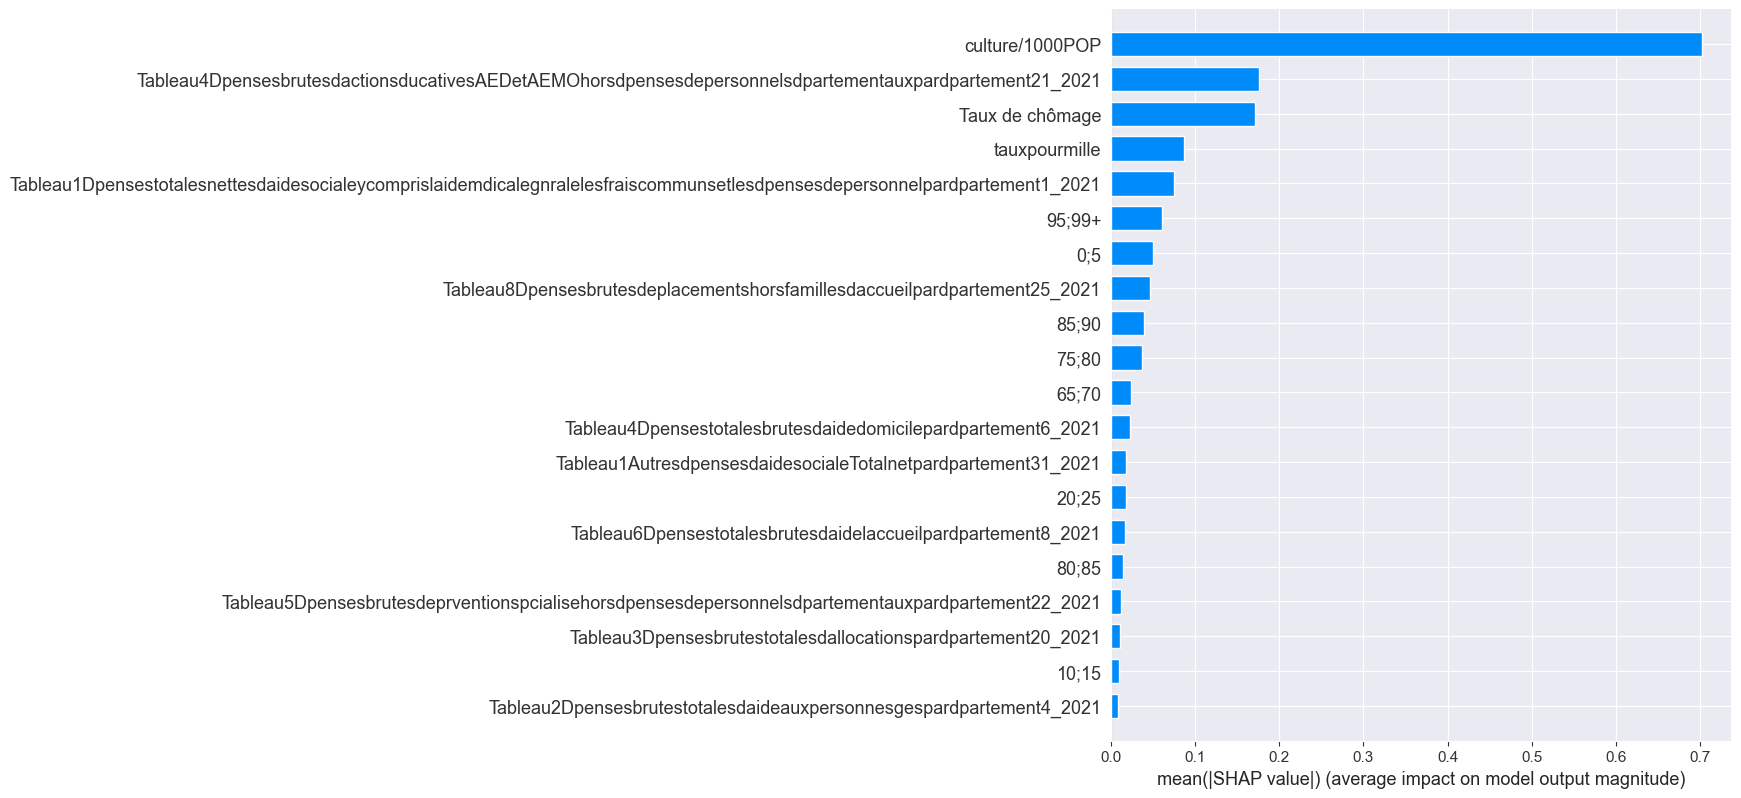

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


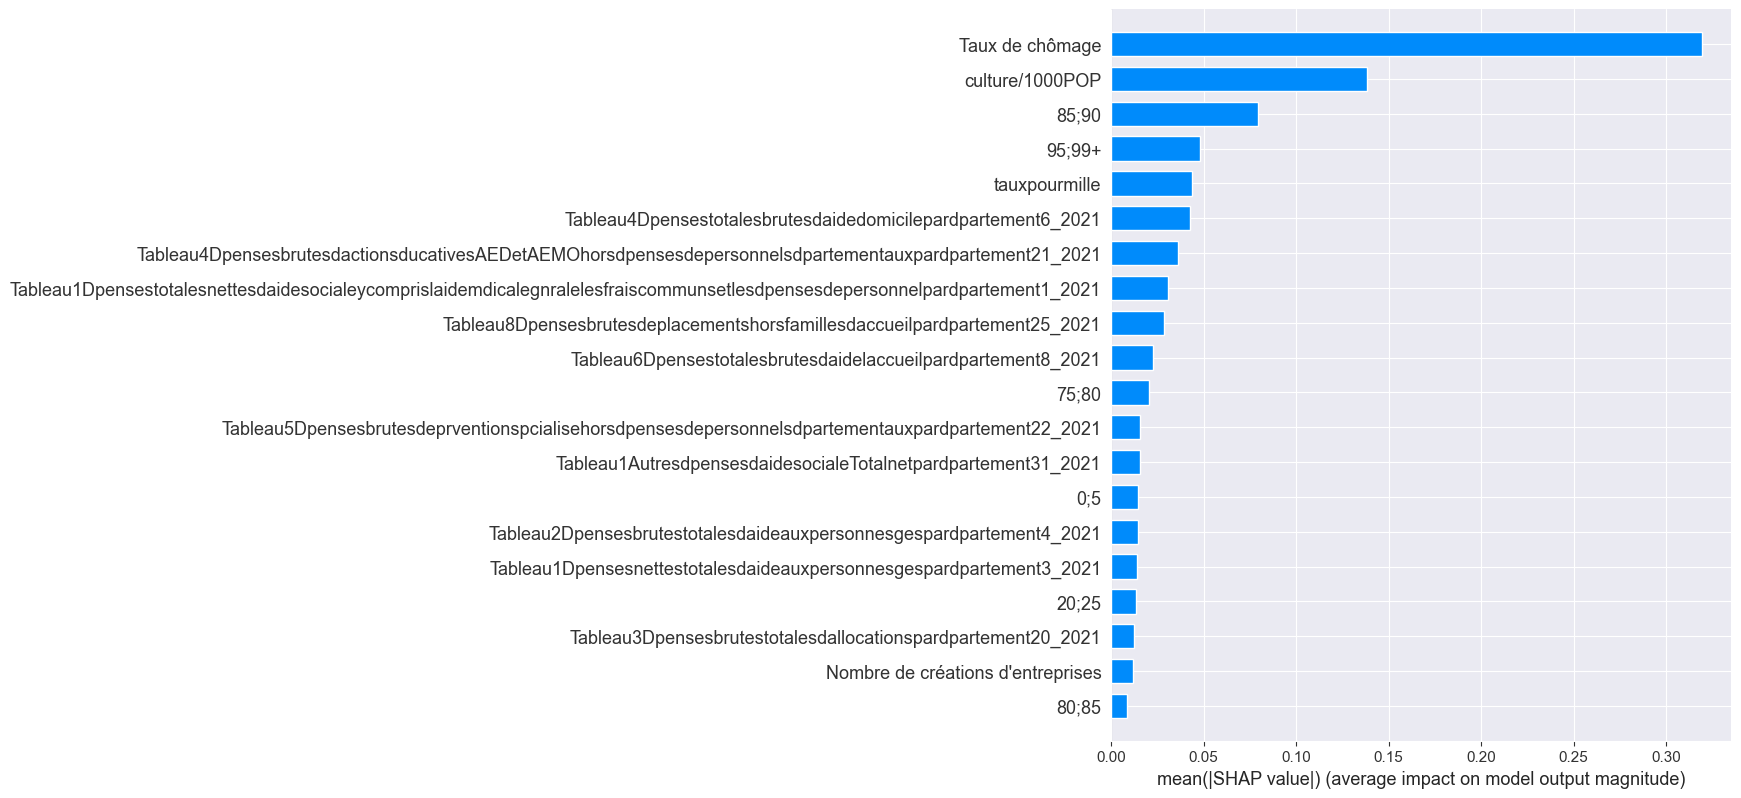

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


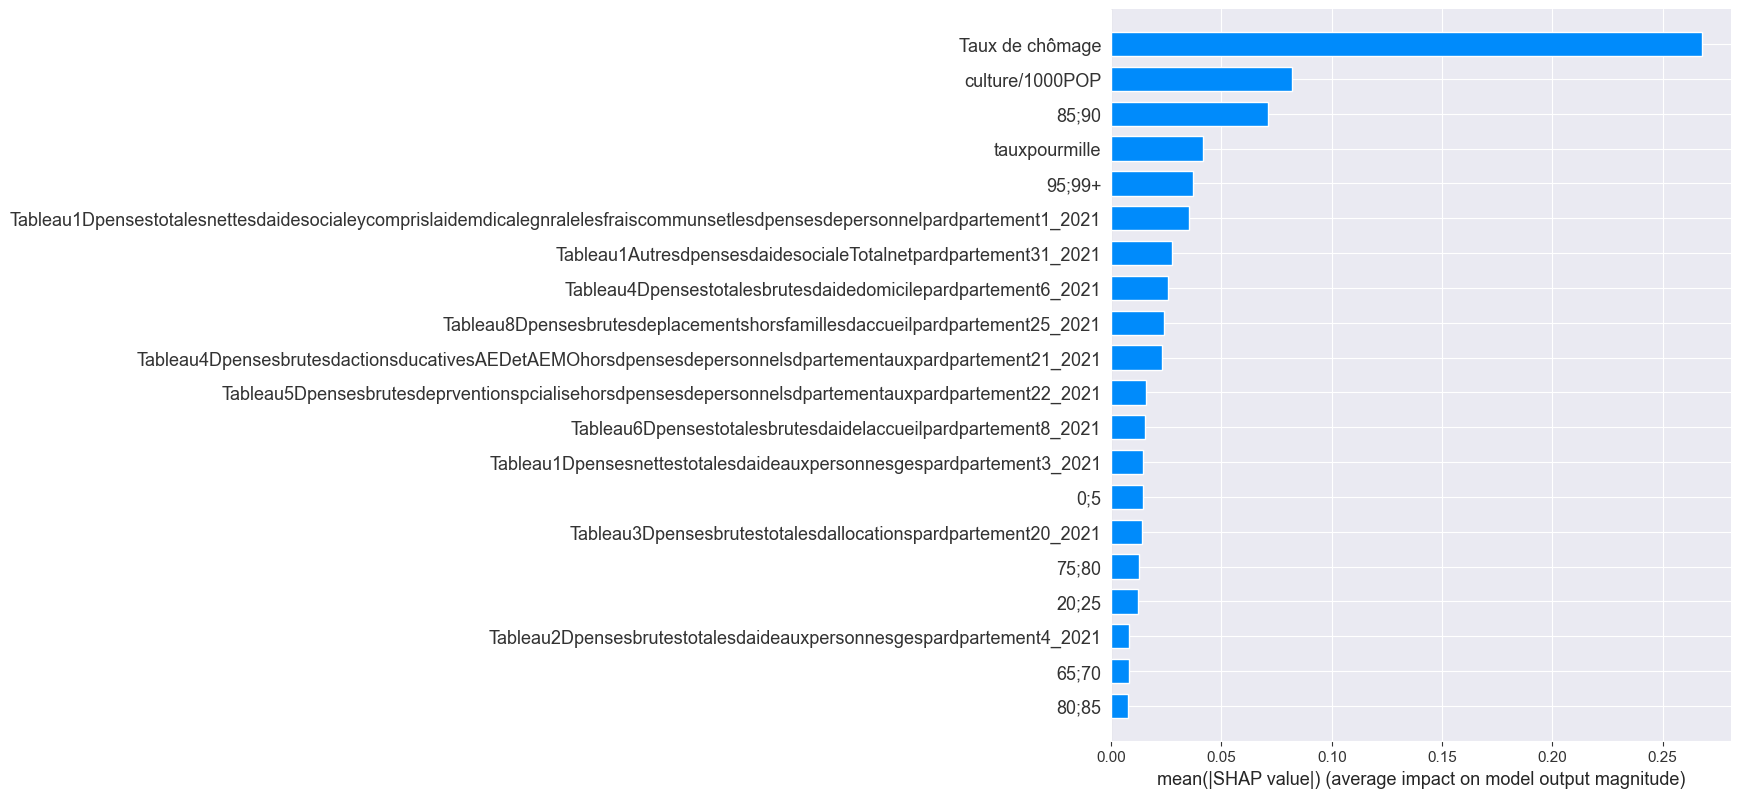

In [67]:
# Afficher les graphiques résumés des valeurs SHAP pour chaque parti politique
shap.summary_plot(shap_values_LFI, features=data_LFI.drop(columns=['gagnant']), plot_type='bar', title='LFI')
shap.summary_plot(shap_values_RN, features=data_RN.drop(columns=['gagnant']), plot_type='bar', title='RN')
shap.summary_plot(shap_values_LREM, features=data_LREM.drop(columns=['gagnant']), plot_type='bar', title='LREM')

## Sur le fond les réuslat semblent concluant mais au niveau de la forme c'est peu lisible. De plus il y a encore beaucoup de colonne ce qui a pu créer du bruit dans le modèle. Notre solution est donc de fusionner des colonnes similaires afin d'avoir des résultats plus claires

In [68]:
# Réduire le bruit en réduisant les colonnes 

# 1 - ages
# enfant 
selected_columns = [col for col in df_winner.columns if col.startswith(('0;', '5;', '10;', '15;'))]
df_winner['0-20'] = df_winner[selected_columns].sum(axis=1)
df.drop(columns=selected_columns, inplace=True)

# jeunes actifs
selected_columns = [col for col in df_winner.columns if col.startswith(('20;', '25;'))]
df_winner['20-30'] = df_winner[selected_columns].sum(axis=1)
df.drop(columns=selected_columns, inplace=True)

# Parents
selected_columns = [col for col in df_winner.columns if col.startswith(('30;', '35;', '40;', '45;', '50;', '55;'))]
df_winner['30-55'] = df_winner[selected_columns].sum(axis=1)
df.drop(columns=selected_columns, inplace=True)

# Retraités 
selected_columns = [col for col in df_winner.columns if col.startswith(('60;', '65;', '70;', '75;'))]
df_winner['60-80'] = df_winner[selected_columns].sum(axis=1)
df.drop(columns=selected_columns, inplace=True)

# Anciens
selected_columns = [col for col in df_winner.columns if col.startswith(('80;', '85;', '90;', '95;'))]
df_winner['0-20'] = df_winner[selected_columns].sum(axis=1)
df.drop(columns=selected_columns, inplace=True)

# 2 - Aides Sociales
selected_columns = [col for col in df_winner.columns if col.startswith('Tableau')]
df_winner['AidesSociales'] = df_winner[selected_columns].sum(axis=1)
df.drop(columns=selected_columns, inplace=True)


df_winner

,tauxpourmille,gagnant,culture/1000POP,total_population,Taux de chômage,Nombre de créations d'entreprises,0-20,20-30,30-55,60-80,AidesSociales
0,40.0,LREM,1.053670,671937,5.4,8417,34820,57020,270160,131200,1.034052e+06
1,46.4,RN,1.583807,522791,10.4,4422,31220,51280,194730,119040,1.344400e+06
2,39.5,RN,2.514717,332443,7.6,3355,30120,29820,115990,90050,9.073738e+05
3,48.9,RN,2.178166,166654,8.2,2629,13590,12420,60110,44480,3.379633e+05
4,43.6,LREM,2.400995,139942,6.8,2484,10950,10350,51900,37570,3.048245e+05
...,...,...,...,...,...,...,...,...,...,...,...
88,55.6,LFI,0.458188,1316053,6.4,23093,60990,157140,517530,216000,4.558815e+06
89,61.5,LREM,0.279537,1642002,5.9,36273,77770,204840,678700,259220,3.015068e+06
90,84.4,LFI,0.202043,1682806,10.2,38726,53300,216570,670680,239130,2.496255e+06
91,65.7,LFI,0.257929,1426748,7.2,28800,65400,191760,569680,231680,1.958073e+06


## En réduisant les colonnes ages et aides sociales nous avons réduit les colonnes a 11, nous pouvons relancer le modèle afin de voir si nous avons gagné de l'accuracy et de la clarté dans nos visualisation

In [69]:
# Diviser les données en features (X) et la cible (y)
X = df_winner.drop(columns=['gagnant'])
y = df_winner['gagnant']

# Convertir les colonnes catégoriques en type 'category'
# cat_cols = X.select_dtypes(include=['object']).columns
# X[cat_cols] = X[cat_cols].astype('category')

# Encoder les catégories en valeurs numériques
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Créer un objet DMatrix pour XGBoost
dtrain = xgb.DMatrix(X, label=y)

from sklearn.model_selection import StratifiedKFold

# Test d'optimisation du model avec les paramètres
params_opti = {
    'objective': 'multi:softmax',  # Objectif de la fonction de perte pour une classification multi-classes
    'num_class': len(np.unique(y)),  # Nombre de classes dans la cible
    'eval_metric': 'merror',         # Métrique d'évaluation (taux d'erreur de classification)
    'learning_rate': 0.2,            # Taux d'apprentissage (vitesse à laquelle le modèle apprend)
    'max_depth': 5,                  # Profondeur maximale de chaque arbre
    'min_child_weight': 3,           # Poids minimum d'un nœud enfant (contrôle de l'overfitting)
    'gamma': 0.2,                    # Réduction minimale de la perte requise pour diviser un nœud
    'subsample': 0.8,                # Fraction des échantillons à utiliser lors de la construction de chaque arbre
    'colsample_bytree': 1.0          # Fraction des caractéristiques à utiliser lors de la construction de chaque arbre
}

num_rounds = 700  # Nombre d'itérations d'entraînement
# Définir la stratégie de validation croisée (K-fold)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Utiliser xgb.cv avec les paramètres et la validation croisée définis
cv_results_test = xgb.cv(params=params_opti, dtrain=dtrain, num_boost_round=num_rounds, folds=kfold, metrics='merror', early_stopping_rounds=1000, seed=42)

print(cv_results_test)
print("Précision moyenne :", 1 - cv_results_test['test-merror-mean'].iloc[-1])

The least populated class in y has only 6 members, which is less than n_splits=10.


     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
0             0.169693          0.020161          0.303333         0.150066
1             0.156483          0.021421          0.323333         0.145080
2             0.144578          0.019641          0.300000         0.110442
3             0.136173          0.018399          0.288889         0.149815
4             0.139773          0.016775          0.311111         0.118530
..                 ...               ...               ...              ...
695           0.026248          0.011683          0.235556         0.092135
696           0.026248          0.011683          0.235556         0.092135
697           0.026248          0.011683          0.235556         0.092135
698           0.026248          0.011683          0.235556         0.092135
699           0.026262          0.008910          0.235556         0.092135

[700 rows x 4 columns]
Précision moyenne : 0.7644444444444445


## Nous avons gagné 0.02 en accuracy (0.74 à 0.76), maintenant nous pouvons analyser le modèle voir si c'est plus clair

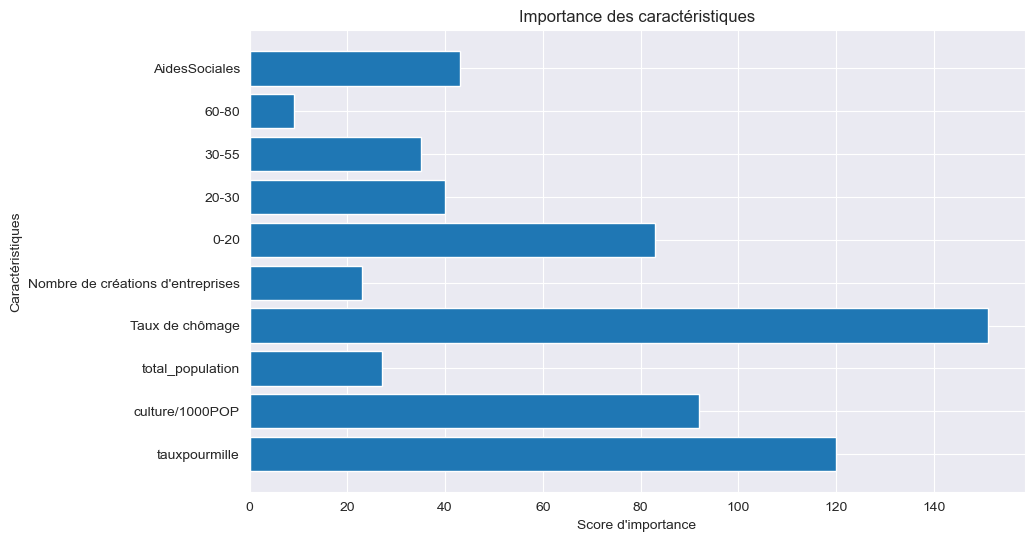

In [70]:
# Entraîner un modèle XGBoost sur l'ensemble des données
model = xgb.train(params_opti, dtrain, num_boost_round=num_rounds)

# Obtenir l'importance des caractéristiques
importance = model.get_score(importance_type='weight')

# Créer une liste de noms de caractéristiques et une liste de scores d'importance
feature_names = list(importance.keys())
scores = list(importance.values())

# Créer un graphique à barres pour afficher l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_names, scores)
plt.xlabel('Score d\'importance')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques')
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


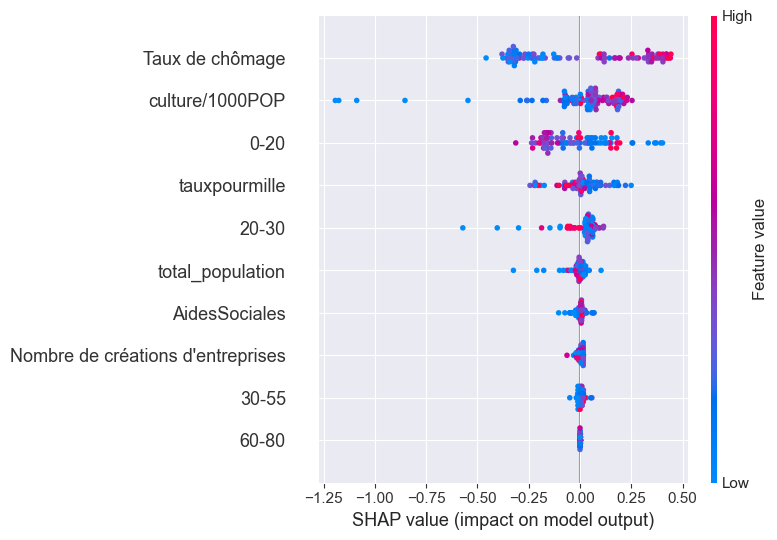

In [71]:
import shap

X2 = X

dtrain2 = xgb.DMatrix(X2, label=y)

params2 = {
    'eval_metric': 'merror'         # Métrique d'évaluation
}

model2 = xgb.train(params2, dtrain2, num_boost_round=num_rounds)


explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(X2)

# Afficher le résumé des valeurs SHAP
shap.summary_plot(shap_values, X2)

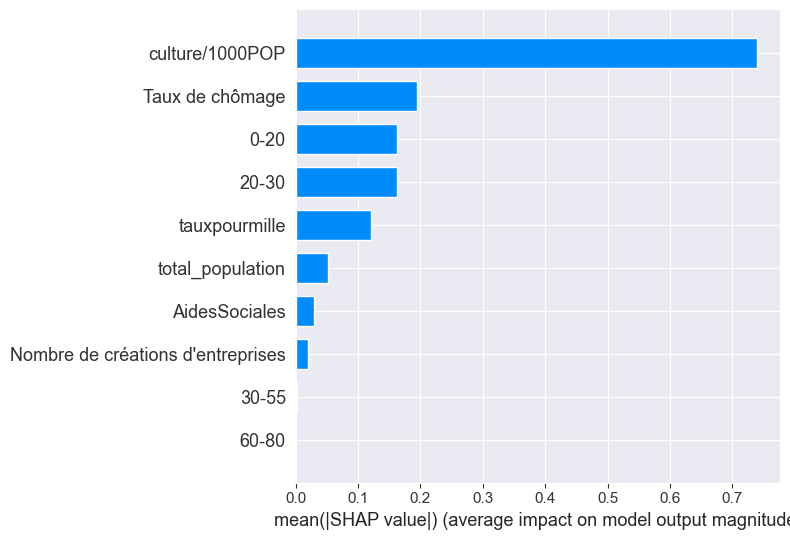

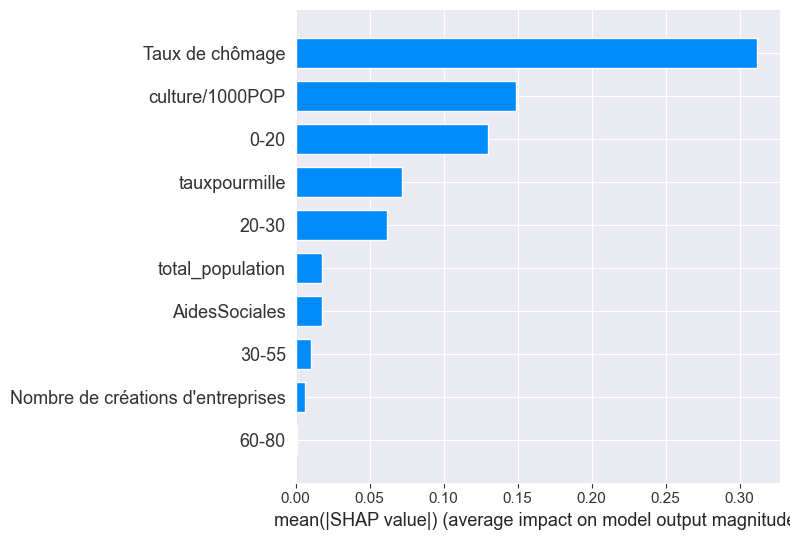

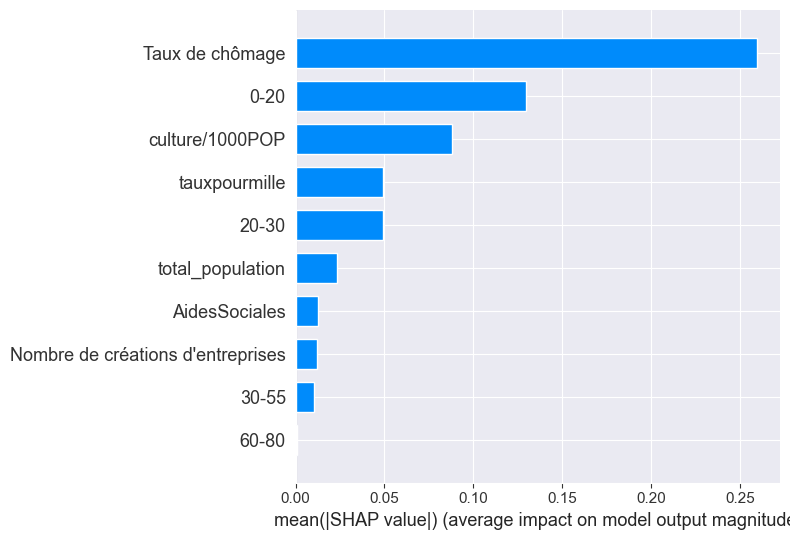

In [72]:
# Analyse des différents impact par parties

# Créer un ensemble de données pour LREM
data_LREM = df_winner[df_winner['gagnant'] == 'LREM']

# Initialiser l'explorateur SHAP avec votre modèle XGBoost
explainer = shap.TreeExplainer(model2)

# Calculer les valeurs SHAP pour chaque ensemble de données

# Pour LREM
shap_values_LREM = explainer.shap_values(data_LREM.drop(columns=['gagnant']))
# Créer un ensemble de données pour RN
data_RN = df_winner[df_winner['gagnant'] == 'RN  ']
# Calculer les valeurs SHAP pour chaque ensemble de données
shap_values_RN = explainer.shap_values(data_RN.drop(columns=['gagnant']))
# Créer un ensemble de données pour LFI
data_LFI = df_winner[df_winner['gagnant'] == 'LFI ']
# Calculer les valeurs SHAP pour chaque ensemble de données
shap_values_LFI = explainer.shap_values(data_LFI.drop(columns=['gagnant']))
# Afficher les graphiques résumés des valeurs SHAP pour chaque parti politique
shap.summary_plot(shap_values_LFI, features=data_LFI.drop(columns=['gagnant']), plot_type='bar', title='LFI')
shap.summary_plot(shap_values_RN, features=data_RN.drop(columns=['gagnant']), plot_type='bar', title='RN')
shap.summary_plot(shap_values_LREM, features=data_LREM.drop(columns=['gagnant']), plot_type='bar', title='LREM')

## On a maintenant un aperçu plus clair de l'importance des données